# Avito Demand Prediction Challenge

## Equipe:
* Catherine dos Santos Tostes - Aluna de Mestrado PPGI
* Felipe Arruda Pontes -  Aluno Ouvinte de Mestrado PPGI
* Jean Gabriel N. Nguema -  Aluno de Mestrado PPGI

No ramo do comércio eletrônico, a venda de produtos através de anúncios classificados em sites conhece um crescimento rápido. No entanto, é comum que anunciantes, indivíduos ou empresas, se frustrem com uma demanda fraca ou inexistente por seus produtos apesar do investimento em propaganda no caso de anunciantes empresariais. Por outro lado, uma demanda alta e persistente por produtos já vendidos causa frustração do anunciante por indicar a venda por um preço a abaixo do preço do mercado. A venda efetiva dos produtos nos sites classificados depende de uma combinação de fatores, que podem fazer uma grande diferença para aumentar o interesse dos consumidores nos produtos. Exemplos desses fatores incluem descrições, imagens, regiões geográficas, etc. Por exemplo, descrições com nuances ou com poucos detalhes e imagens de pouca qualidade podem reduzir o interesse dos consumidores.

A AVITO, maior site de anúncios classificados na Rússia, está acostumado com a frustração dos seus anunciantes e busca formas de reduzi-la. Com esse objetivo, ela patrocina uma competição iniciada no mês de maio de 2018 através da Kaggle. A Kaggle é uma empresa, que possui uma plataforma aberta na qual cientistas, pesquisadores e profissionais do mundo inteiro na área de ciência de dados são desafiados a resolver problemas reais e complexos de empresas por meio de competições. 

A “competição Avito” da Kaggle desafia pesquisadores a predizer a probabilidade da compra de qualquer produto em função das informações fornecidas no anúncio da plataforma da AVITO. Essas informações incluem a descrição (título, detalhes, etc.), o contexto (a cidade onde o anúncio foi emitido e anúncios já postados) e o histórico da demanda para anúncios similares no contexto. O dataset que reúne informações de todos os anúncios classificados possui cerca de 7 GB. A competição já conta com mais de 1000 equipes. Com as previsões, a AVITO espera dar um retorno aos anunciantes sobre como otimizar suas carteiras de produtos, além de fornecer aos anunciantes indicadores sobre o potencial interesse dos consumidores em seus anúncios.



## Importando módulos e Bibliotecas

Será importado os módulos e bibliotecas que serão necessárias.

Para reproduzir este esperimento é necessário instalar as bibliotecas que foram utilizadas, através da ferramenta [Pipenv](https://github.com/pypa/pipenv/) (o gerenciador de pacotes e ambientes Python definido como padrão pela comunidade Python). 

In [1]:
%matplotlib inline  
import gc
import operator
import os
import pickle
import re
import warnings

import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse import hstack, csr_matrix
import scipy.stats as st


from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_validate, train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import FeatureUnion

from rake_nltk import Rake


from xgboost import XGBRegressor, plot_importance

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/arruda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 1. Carregamento dos datasets  (Train e Test) 


Iremos carregar e ler o arquivo de treinamento e o arquivo de teste que estão disponíveis com o nome de train.csv.zip e test.csv.zip respectivamente, será utilizado o DataFrame do Pandas, que é uma biblioteca para auxiliar na análise de dados tabulares bidimensionais.

In [2]:
train_complete_df = pd.read_csv('train.csv.zip', compression='zip', index_col = "item_id")
submission_df = pd.read_csv('test.csv.zip', compression='zip', index_col = "item_id")

# 2. Exploração dos dados
Antes de criar modelos de predições vamos explorar os dados para descobri suas caracteristicas, seus significados.

Primeiro vamos verificar a quantidade de anúnicos para:
* Treinamento (train) dos modelos
* Submissão (submission) das predicões na competição

In [3]:
print('Train: ',train_complete_df.shape[0], '; Submission: ',submission_df.shape[0])

Train:  1503424 ; Submission:  508438


Verificamos campos do dataset de treinamento (train). Podemos notar que os campos estão descritos em russo. Campos do dataset:
* item_id: Contém a String de código de cada item à venda.
* user_id: Contém a String de código de cada usuário.
* region: De qual região da Rússia faz parte.
* city: De qual cidade da Rússia faz parte.
* parent_category_name: Nome da categoria que o produto faz parte.
* category_name: Nome da subcategoria que o produto faz parte.
* param_1: Parâmetro do produto.
* param_2: Parâmetro do produto.
* param_3: Parâmetro do produto.
* title: Título do produto à venda.
* description: Descrição do produto à venda.
* price: Preço do produto.
* item_seq_number: Número de sequência do produto.
* activation_date: Data de divulgação do produto.
* user_type: Tipo de usuário (se é pessoal ou empresarial).
* image: Imagem.
* image_top_1: Tamanho da Imagem.
* deal_probability: Probabilidade de venda do produto.

In [4]:
print('Número de colunas: ', train_complete_df.shape[1])
train_complete_df.head(3)

Número de colunas:  17


,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
item_id,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177


* Verificamos abaixo que dataset de submissão tem todos os campos do train com excecão do campo 'deal_probabality' que é justamente o campo das predições.

In [5]:
print('Número de colunas: ', submission_df.shape[1])
submission_df.head(3)

Número de colunas:  16


,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
item_id,,,,,,,,,,,,,,,,
6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0


Para cada campo do train, vamos verificar o percentual de valores nulos; por exemplo, o percentual de descrições não preenchidas pelos anunciantes no total das descrições. Essas informações servirão para o pre-processamento/tratamento dos dados.

In [6]:
round(train_complete_df.isnull().sum()*100/train_complete_df.shape[0],2)

user_id                  0.00
region                   0.00
city                     0.00
parent_category_name     0.00
category_name            0.00
param_1                  4.10
param_2                 43.54
param_3                 57.37
title                    0.00
description              7.73
price                    5.68
item_seq_number          0.00
activation_date          0.00
user_type                0.00
image                    7.49
image_top_1              7.49
deal_probability         0.00
dtype: float64

Tendo essas informações, vamos agora visualizar algumas estatísticas com gráfios.

Primeiro definimos algumas funções auxiliadoras utilizadas para gerar as estatísticas

In [7]:
def stringToBold(str_):
    '''Formata uma string para o negrito
    Entrada:
        str_: a string
    Saida:
        string str_ em negrito
    '''
    return "\033[1m"+str_+"\033[0;0m"
  

def plotPieByColumn(grp_column):
    '''Plota um gráfico em pizza para mostrar as proporções em agrupamento por uma coluna.
        Entrada:
            grp_column: dataframe com agrupamentos, cada um contendo seu número de anúncios
        Saída:
            Plota um gráfico em pizza para mostrar as proporções em agrupamento por uma coluna.
    '''
    column_name=grp_column.index.name
    
    print(
        stringToBold('Número possível de {0}: {1}'.format(column_name, len(grp_column.index)) )
    )
    print('----------------------------------')
    dic_column={}
    column_values=[]
    numbers=[]
    
    for row in grp_column.itertuples():
        grp_column_item=row[0]
        column_value=row[1]
        dic_column[grp_column_item]=column_value
        numbers.append(column_value)
    column_values=list(dic_column.keys())
    
    entity_data = {'{0}'.format(column_name): column_values,'number': numbers}
    df_ = pd.DataFrame(entity_data, columns = ['{0}'.format(column_name), 'number'])
    
    plt.figure(figsize=(16,8))
    # plot chart
    ax1 = plt.subplot(121, aspect='equal')
    df_.plot(kind='pie', y = 'number', ax=ax1,  autopct='%1.1f%%', startangle=90, shadow=False, 
              labels=df_['{0}'.format(column_name)], legend = False, fontsize=14, 
             title='Percentual de anúncios por {0}'.format(column_name)
             )
    ax2 = plt.subplot(122)
    plt.axis('off')
    
    plt.show()
    

#### Distribução de tipo de anunciante (user_type)

Número possível de user_type: 3
----------------------------------


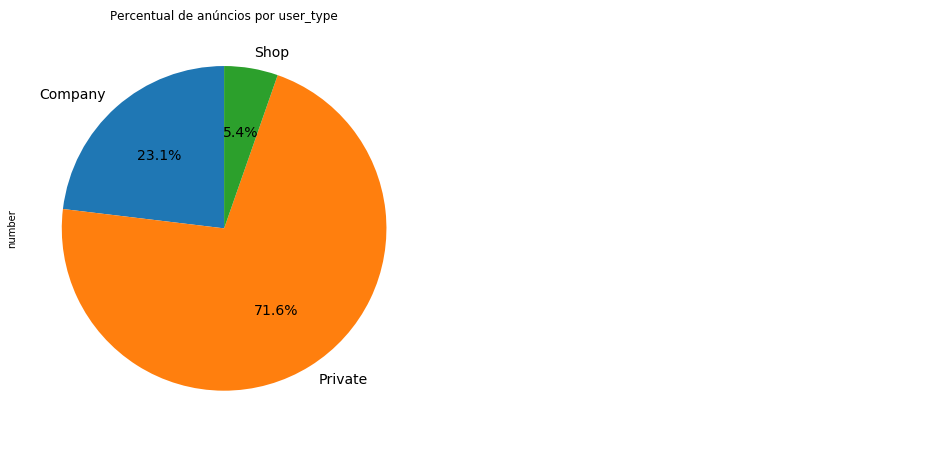

In [8]:
plotPieByColumn(
    train_complete_df[['user_type','title']].groupby('user_type').count()
)

#### Distribução de parent_category _name

Número possível de parent_category_name: 9
----------------------------------


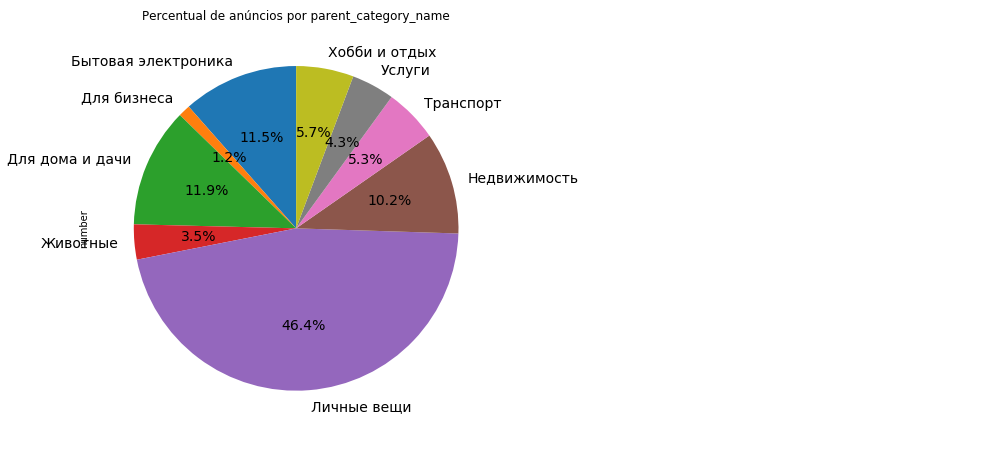

In [9]:
plotPieByColumn(
    train_complete_df[['parent_category_name','title']].groupby('parent_category_name').count()
)

#### Distribução de category_name

Primeiro definimos outras funções auxiliadoras a serem usadas por vários campos

In [10]:
def describeAdsByColumn(column, title_,top_number=30):
    '''Mostra a distribução de anúncio por uma coluna do dataset
    Entrada:
        column: nome da coluna (String). Exemplo:'region, 'category_name', etc.
        top_number: valor inteiro para selecionar o ranking dos maiores em anúncios 
    Saída:
        Gráfico em barra da distribução de anúnicos pela coluna informada
    '''
    
    #Números de anúncios por Colunas
    column_number_of_ads= train_complete_df[column].value_counts()
    #Guardar os valores da coluna
    column_values = np.array(column_number_of_ads.index) #regions_names
    
    #Imprimir a quantidade de valores no campo
    
    print(
        stringToBold("                    Número de valores no campo {0}: ".format(column)+ 
          str(len(column_values))))
        
    
    #Guardar os números de anuncios dos valores na coluna
    ads_numbers= np.array(column_number_of_ads)
    
    #Criar um dataframe com as informações anterios
    df_column_ads_ = pd.DataFrame({'{0}'.format(column): column_values, 'number of ads': ads_numbers})
  
    df_column_ads=df_column_ads_.groupby('{0}'.format(column)).sum().sort_values('number of ads', 
                            ascending=False).nlargest(top_number, columns=['number of ads'])
    
    df_column_ads.plot.barh(title=title_)
    plt.show()

                    Número de valores no campo category_name: 47


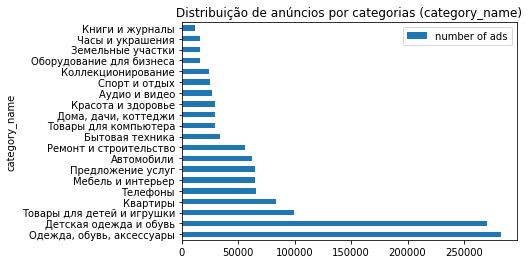

In [11]:
describeAdsByColumn('category_name', 'Distribuição de anúncios por categorias (category_name)', 
                    top_number=20)

#### Distribução de anúncios por região

                    Número de valores no campo region: 28


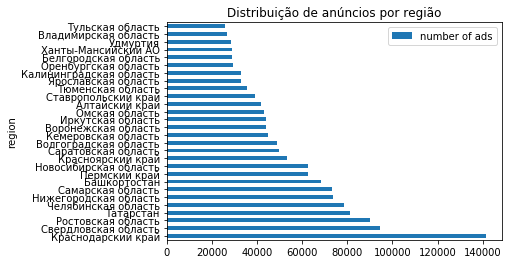

In [12]:
describeAdsByColumn('region', 'Distribuição de anúncios por região')

#### Distribução de anúncios por cidades

                    Número de valores no campo city: 1733


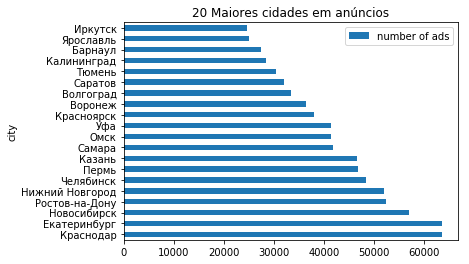

In [13]:
describeAdsByColumn('city', '20 Maiores cidades em anúncios', top_number=20)

#### Quantidades de valores únicos nos campos: param_1, param_2 e param_3

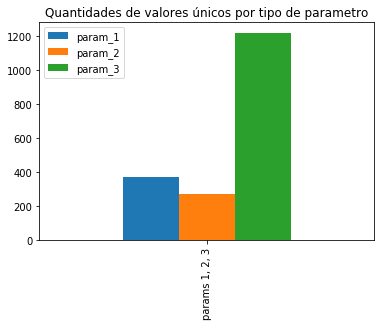

In [14]:
pd.DataFrame({'param_1': len(train_complete_df['param_1'].unique()), 
            'param_2': len(train_complete_df['param_2'].unique()) ,
            'param_3': len(train_complete_df['param_3'].unique())},
             index=['params 1, 2, 3']).\
             plot.bar(title='Quantidades de valores únicos por tipo de parametro')
plt.show()

#### Análise sobre os preços
Primeiro verificamos algumas estatísticas sobre o preço, incluindo a media, médiana, desvio padrão, etc.
*  Pelos dados abaixo: 75% dos anúncios tem preço abaixo de 6000 dolares. O histograma abaixo apresenta uma distribução do preço.
* Plotamos então um histograma para visualizar melhor os preços abaixo dessa quantia

In [15]:
price_df=train_complete_df[['price']]
price_df=price_df.fillna(0.0)
round(price_df.describe(),2)

,price
count,1.503424e+06
mean,2.987259e+05
std,6.496484e+07
min,0.000000e+00
25%,4.000000e+02
50%,1.000000e+03
75%,6.000000e+03
max,7.950101e+10


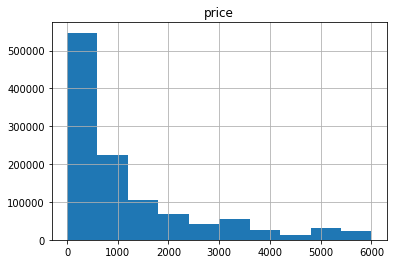

In [16]:
price_df[price_df.price<=6000].hist()
plt.show()

#### Estatísticas sobre os campos descrição e título

Primeiro definimos funções auxiliadores para obter essas informações.

In [17]:
def describeTextColumn(column):
    '''Dado um campo de texto, descreve estatítisca sobre a quantidade de caracteres do campo 
    no dataset do train: media, mediana, desvio padrão, máximo, mínimo, etc.
    plota tambem a distribução da quantidade de caracteres no campo.
    Entrada:
        column: coluna do train, de preferência description ou title
    Saída:
        apresenta as estatísticas e plota a distribução.
    
    '''
    desc_df=train_complete_df[[column]]
    desc_df=desc_df[[column]].fillna('')
    descriptions=list(desc_df[column].values)
    
    len_list=getLenghts(descriptions)
    df= pd.DataFrame(
        {'desc_length': len_list}, 
        index=train_complete_df.index)
    print(df.describe())
    plt.hist(df['desc_length'].values)
    plt.title('Distribuição de {0}'.format(column))
    plt.show()
    
    #return df

def getLenghts(corpus_):
    '''Obter o tamanho de cada elemento de uma lista de string.
    Entrada:
        corpus_:lista de string. 
    Saída:
        len_list:lista de tamanhos (int) das strings de entrada
    '''
    len_list=[]
    for i in range(0,len(corpus_)):
        len_list.append(len(corpus_[i]))
    return len_list

#### Estatísticas sobre o campo Descrição

        desc_length
count  1.503424e+06
mean   1.779707e+02
std    2.881340e+02
min    0.000000e+00
25%    4.100000e+01
50%    8.700000e+01
75%    1.860000e+02
max    3.212000e+03


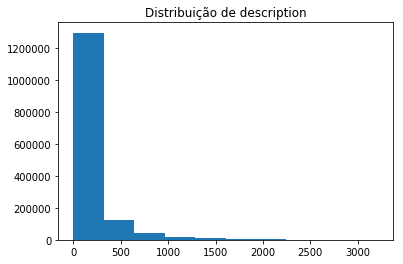

In [18]:
describeTextColumn('description')

#### Estatísticas sobre o campo título

        desc_length
count  1.503424e+06
mean   2.139313e+01
std    1.099126e+01
min    1.000000e+00
25%    1.300000e+01
50%    2.000000e+01
75%    2.800000e+01
max    5.600000e+01


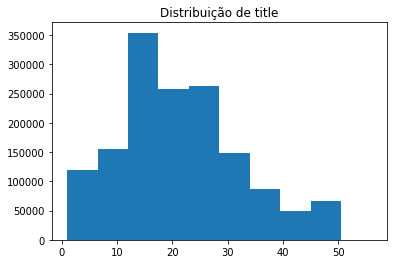

In [19]:
describeTextColumn('title')

#### Distribuição da probabilidade de Venda

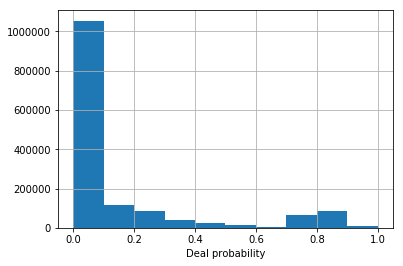

In [20]:
plt.hist(train_complete_df['deal_probability'])
plt.xlabel('Deal probability')
plt.grid(True)
plt.show()

# 3. Descrição de soluções intermediárias

Até chegar à solução final apresentada mais adiante, tivemos várias abordagens que resultaram em scores intermediários no kaggle. Apresentamos aqui uma visão geral sobre as mesmas, e disponizamos seus links para conferência ou acesso aos detalhes.

## Regressão vs Classificação
**Algoritmos avaliadaos**: LinearRegression, SVR, SGDRegressor, MLPRegressor, Multinomial Naive Bayes, Gaussian Naive Bayes e MLPClassifier

Foram utilizados 7 algoritmos, sendo  4 de regressão. Usou-se um cross-validation entre os algoritmos de regressão, e outro cross validation entre os de classificação. Os algoritmos de regressão apresentaram desempenho superior conforme evidenciado por gráficos (vide link). O **LinearRegression** teve o melhor desempenho e foi escolhido para a submissão. 
**Como features**, a abordagem utilizou estatísticas de probabilidades médias  nos campos **user_type, region, category_name, region, city, preços**, probabilidades por categoria de preços  e distribuição de frequências dos campos como user_type, region. etc. Usou-se tambem o LabelEncoder para transformar as targets (deal_probability) de valores contínuos para discretos para serem aceitos por algritmos de classificação.

**Score Final:** 0,2489

Disponivel em: https://github.com/arruda/avito_challenge/blob/master/Jean_All_NFeat_V02-2489.ipynb

## Random Forest Regressor

Foi realizado a técnica de pré-processamento LabelEncoder para transformar os valores categóricos das colunas  title, region, city, parent_category_name, category_name, param_1, user_type, user_id, param_2, param_3, description, image em valores numéricos inteiros e aplicado o classificador Random Forest Regressor, onde seu estimador ajusta as árvores de decisão em sub-amostras do conjunto de dados e faz uso da média para melhorar a predição.

**Score Final:** 0,2460


Disponível em: https://github.com/arruda/avito_challenge/blob/master/Catherine_random_forest_regressor.ipynb



## Analise de sentimento
Tentamos aplicar uma analise de sentimento utilizando uma biblioteca em Python própria para a lingua russa ([Sentimental](https://github.com/text-machine-lab/sentimental)). 

Porém a biblioteca não tinha um bom dicionário Russo para gerar resultados que pudessem ajudar de fato. E dado a disponibilidade de tempo seria impossível traduzir todos os textos para fazer uso de bibliotecas otimizadas para lingua inglesa.

**Score Final:** 0.2686

Disponívem em: https://github.com/arruda/avito_challenge/blob/master/arruda-xgb-uppercases-and-all-usable-fields-sentiment.ipynb

# 4. Solução Final
Após diversos experimentos com diferentes features e modelos, conseguimos chegar à um bom resultado. Para isso utilizamos o modelo XGBRegressor (para regressões utilizando o XGBoost) e usamos a maioria das features presentes no dataset, além outras derivadas dos campos de texto. 

Essa abordagem será tratada em detalhes adiante.


## Funções de auxilio para leitura e escrita em disco

In [3]:
def save_to_disk(pkl_filename, data):
    '''Salva em disco algum dado.
      Util para salvar e recarregar modelos, parametros, 
      e resultados de algoritmos demorados calculados anteriormente.
    
    Entrada:
        pkl_filename: nome do arquivo onde será salvo o dado.
        data: dado à ser salvo.
    
    '''  
    with open(pkl_filename, 'wb') as f:
        pickle.dump(data, f)
        
        
def load_from_disk(pkl_filename):
    '''Carrega do disco algum dado.
      Util para salvar e recarregar modelos, parametros, 
      e resultados de algoritmos demorados calculados anteriormente.
    
    Entrada:
        pkl_filename: nome do arquivo de onde será carregado o dado.
    
    Saída:
        objeto python carregado em memoria.
    '''    
    with open(pkl_filename, 'rb') as f:
        pickle_data = pickle.load(f)
        return pickle_data

## Tratamento do dataset

Para tornar mais prático o tratamento dos dados, os datasets de treino e de teste  são concatenados. Assim as operações do tratamento das features serão executadas apenas uma vez.  Posteriormente os datasets serão novamente separados.

Salva os indices dos datasets de treino e de teste, posteriormente esses indices serão usados para separar o que é parte do dataset de treino e o que é parte do dataset de teste.

In [4]:
train_complete_index = train_complete_df.index
submission_index = submission_df.index

Salva a solução (*deal_probability*) do dataset de treino em uma variável *y* que será utilizada mais para frente. 

In [5]:
y = train_complete_df['deal_probability'].copy()

Em seguida remove essa coluna do dataset de treino. Isso é necessário para que possamos concatenar os datasets de treino e de teste.


In [6]:
train_complete_df.drop("deal_probability",axis=1, inplace=True)
full_df = pd.concat([train_complete_df,submission_df], axis=0)

Remove os datasets de treino e de teste, uma vez que agora temos um dataset completo com os dois.

Isso é necessário para liberar o espaço em memoria usado por essas variaveis, que é consideravel.

In [7]:
del train_complete_df, submission_df

### Tratamento nos campos de texto

#### Funções auxiliares para tratamento dos campos de texto

In [8]:
def apply_uppercases_and_num_words(df, col_name):
    '''Gera novas colunas, uma com a proporção de caracteres em caixa alta nos
    textos de uma coluna expecifica do dataset (`col_name`), 
    além de outra com a quantidade de palavras. 
    O nome das novas colunas segue o padrão `perc_upper_cases_<nome_da_coluna>`
    e `num_words_<nome_da_coluna>`.
    
    Entrada:
        df: dataset onde sera gerado as novas colunas
        col_name: Nome da coluna de onde serão analisados os textos
        
    Saída:
        dataset com as novas colunas
    
    '''
    uppercases = []
    perc_uppercases = []
    total_num_words = []
    for text in df[col_name]:
        text = str(text)
        # remove numeros
        text = re.sub('[0-9]+', '', text)
        
        total_uppers = sum(1 for c in text if c.isupper())
        uppercases.append(total_uppers)
        total = len(text)
        if total == 0:
            perc = 0.0
        else:
            perc = total_uppers/total
        num_words = len(text.split(' '))
        total_num_words.append(num_words)

        perc_uppercases.append(perc)
    
    df[f'perc_uppercases_{col_name}'] = perc_uppercases
    df[f'num_words_{col_name}'] = total_num_words
    return df

  
def return_text_cols_reduced(df):
    '''Para cada texto na coluna `description` do dataset passado, aplica
        o algoritmo RAKE (Rapid Automatic Keyword Extraction) 
        para determinar quais as palavras-chave mais importantes do texto.
        Por fim seleciona apenas aquelas palavras que tem o rank maior ou igual
        ao rank medio de todas as palavras-chave do texto.
        
        Carrega os dados em disco, caso os mesmos já tenham 
        sido executados anteriomente.
    
    Entrada:
        df: dataset onde será aplicado o RAKE
        
    Saída:
        vetor com descrições reduzidas, utilizando apenas as palavras-chave 
        mais importantes.
    
    '''
    try:
        description_reduced = load_from_disk('description_reduced.pkl')
    except:
        r = Rake(language='russian')

        total = df['description'].shape[0]

        verbose_step_size = int(total/10)
        description_reduced = []
        for i, description in enumerate(df['description']):
            r.extract_keywords_from_text(description)
            phrases_and_scores = r.get_ranked_phrases_with_scores()  
            if len(phrases_and_scores) <= 1:
                description_reduced.append(description)
                continue
            mean_score = np.mean([x[0] for x in phrases_and_scores])

            highest_phrases = [x[1] for x in phrases_and_scores if x[0] >= mean_score]
            reduced_description = ' '.join(highest_phrases)
            description_reduced.append(reduced_description)

            if i % verbose_step_size == 0:
                print(f'{int(i/total*100)}') 
        save_to_disk('description_reduced.pkl', description_reduced)
                
        
    return description_reduced

  
def vectorized_texts_and_features(df):
    '''Gera um vectorizer dos campos `description_reduced` e `title`.
    Para tal utiliza o TfidfVectorizer em ambos os campos,
    mas limitando o numero de features no campo `description_reduced`.
    
    Entrada:
        df: dataset usado como origem para o vectorizer
        
    Saída:
        Matriz de features TF-IDF.
    
    '''  
    stop_words = stopwords.words('russian')

    tfidf_params = {
        "token_pattern": r'\w{1,}',
        "analyzer": 'word',
        "sublinear_tf": True,
        "dtype": np.float32,
        "norm": 'l2',
        "stop_words": stop_words,
        "smooth_idf":False
    }

    vectorizer = FeatureUnion([
        ('description_reduced',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=16000,
            **tfidf_params,
            preprocessor=lambda x: x['description_reduced'])),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_params,
            preprocessor=lambda x: x['title']))
    ])


    vectorizer.fit(df[['description_reduced', 'title']].to_dict('records'))
    return vectorizer

    
def get_text_transformed_and_features_name(df):
    '''Transforma os dados das colunas de `description_reduced` e `title` em uma 
    document-term matrix utilizando o TF-IDF.
    
        Carrega os dados em disco, caso os mesmos já tenham 
        sido executados anteriomente.
    Entrada:
        df: dataset usado como base para as operações.
        
    Saída:
        (text_transformed, tfidf_features_name): Tupla onde o primeiro elemento
         é a document-term matrix das colunas `description_reduced` e `title` 
        e o segundo elemento é o vetor com os nomes das features geradas.
    
    '''  
    try:
        text_transformed = load_from_disk('text_transformed.pkl')
        tfidf_features_name = load_from_disk('tfidf_features_name.pkl')
    except:
        vectorizer = vectorized_texts_and_features(df)
        text_transformed = vectorizer.transform(df.to_dict('records'))
        tfidf_features_name = vectorizer.get_feature_names()
        save_to_disk('text_transformed.pkl', text_transformed)
        save_to_disk('tfidf_features_name.pkl', tfidf_features_name)
    return text_transformed, tfidf_features_name


Com essas funções auxiliares podemos agora tratar as features de texto do dataset.

Primeiro trocamos os valores de descrição que são nulos por string vazias

In [9]:
full_df['description'] = full_df['description'].replace(np.nan, '', regex=True)

Em seguida criamos as novas features com a porcentagem de caracteres em caixa alta e com o numero de palavras tanto para os textos de *description* quanto para os textos de *title*.

In [10]:
full_df = apply_uppercases_and_num_words(full_df, 'description')
full_df = apply_uppercases_and_num_words(full_df, 'title')

Utilizamos o algoritmo RAKE (Rapid Automatic Keyword Extraction) e geramos uma nova feature chamada *description_reduced* representando os campos *description* mas apenas com as palavras-chave mais importantes. 

Isso é importante pois utilizar toda a descrição acabou sendo inviável em termos de uso de memoria ao gerar o document-term matrix das features de  texto.

In [11]:
full_df['description_reduced'] = return_text_cols_reduced(full_df)


Transformamos então os dados das colunas de *description_reduced* e *title* em uma  document-term matrix utilizando o TF-IDF.

salvamos também o nome das features representando cada coluna dessa matrix, pois mais à frente vamos usar esses dados.

In [12]:
text_transformed, tfidf_features_name = get_text_transformed_and_features_name(full_df)

### Tratamento nos campos numericos

A ideia é preencher os campos de *price* e *image_top_1* com valores negativo no lugar dos valores nulos.

Além disso é aplicado uma função de log no preço para fique numa escala logaritmica. 

In [13]:
full_df['price'] = np.log(full_df['price']+0.001)
full_df['price'].fillna(-999,inplace=True)
full_df['image_top_1'].fillna(-999,inplace=True)

### Tratamento nos campos de categorias 

Todos os campos que são um tipo de categoria serão processados usando um LabelEncoder, como estes os campos:

*image_top_1*, *city*, *region*, *parent_category_name*, *category_name*, *user_type*, *param_1*.


In [14]:
label_encoder = preprocessing.LabelEncoder()
cat_features = [
    'image_top_1',
    'city',
    'region',
    'parent_category_name',
    'category_name',
    'user_type',
    'param_1'
]
for feature_name in cat_features:
    print(f'encode {feature_name}')
    full_df[feature_name] = label_encoder.fit_transform(full_df[feature_name].astype(str))

encode image_top_1
encode city
encode region
encode parent_category_name
encode category_name
encode user_type
encode param_1


Terminado os tratamentos necessários, podemos novamente separar o que era parte do dataset de treinamento e o que era parte do dataset de teste (utilizando os indices salvos anteriormente)

In [15]:
train_complete_df = full_df.loc[train_complete_index,:].copy()
submission_df = full_df.loc[submission_index,:].copy()

Feito isso podemos remover o dataset intermediario (*full_df*) e utilizar o garbage collector do python para garantir que teremos mais memoria disponivel para o restante das operações

In [16]:
del full_df
gc.collect()

74

## Definição das features

Começamos defindo algumas das features já conhecidas no dataset:

In [17]:
features = [
    'price', 
    'item_seq_number', 
    'image_top_1', 
    'city',
    'region',
    'parent_category_name',
    'category_name',
    'user_type',
    'param_1'
]

Vamos usar também as features de porcentagem de caixas altas e numero de palavras geradas para o *titulo* e *descrição*

In [18]:
features.extend([
    'perc_uppercases_description',
    'perc_uppercases_title',
    'num_words_description',
    'num_words_title',
])

# lista com o nome de todas as features que serão usadas no modelo
final_features_list = features + tfidf_features_name

### Junção das features do dataset com as features de texto vetorizadas

Em seguida montamos uma estrutura de dados que junta os dados das features definidas anteriormente com as features geradas a partir dos dados textuais.

Novamente, para separar as features textuais originarias do dataset de treino e do dataset de teste, usamos os indices destes dataset definidos quando estes foram carregados.

In [19]:
X = hstack([
    csr_matrix(train_complete_df[features].values),  # pega as features do dataset de treino
    text_transformed[0:train_complete_index.shape[0]] # pega as features de texto do dataset de treino
])

# mesma coisa para o dataset de teste
submission_X = hstack([csr_matrix(submission_df[features].values), text_transformed[train_complete_index.shape[0]:]])


### Separação entre train/test

Foi realizada a separação dos dados do dataset completo de treino através do train_test_split que divide os arrays e/ou matrizes em subconjuntos de dados aleatórios.

Foi dividido entre 80% à ser usado como treino dos modelos, e 20% para validação dos mesmos.

Definimos um random_state para que o experimento fosse reprodutivel com os mesmos resultados.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123654)

## Comparativo entre modelos

Para facilitar a criação, a execução e a plotagem dos scores dos modelos, utilizamos algumas das funções definidas neste notebook como base (https://nbviewer.jupyter.org/gist/VictorGarritano/2aa620c41d0990bc36bbc4f76dc9434f#), com apenas algumas poucas alterações.

In [21]:
def create_model(klass, **params):
    '''Inicializa o model, com os argumentos que são passados opcionalmente
    
    Entrada:
        klass: Classe do modelo
        **params: Parâmetros a serem passados para o modelo, no momento da inicialização
        
    Saída:
        O modelo inicializado
    '''
    c = klass()
    c.set_params(**params)
    return c

  
def compute_score(klass, X_train, y_train, k=10, 
                scoring=['neg_mean_squared_error'], rt_train=False):
    '''Realiza o treinamento e a validação, utilizando o cross-validation, e calcula as métricas desejadas

    Entrada:
        klass: modelo a ser treinado
        X_train: Conjunto de dados de treinamento
        y_train: resultados de cada exemplo do conjunto de dados
        k: Quantidade de folds a serem usados na cross-validation; a cada iteração (k-1) folds 
            são usados para treino e o fold remanescente é utilizado para validação
        scoring: Lista de métricas a serem calculadas para cada iteração da cross-validation
        rt_train: Decide se as métricas calculadas para o conjunto de treinamento são retornadas ou não

    Saída:
        scores: Dicionário contendo as métricas de cada iteração da cross-validation

    '''
    scores = cross_validate(klass, X_train, y_train, cv=k, scoring=scoring, return_train_score=rt_train)        
    return scores

  
def plot_metric(clf_scores, metrics):
    '''Plota métricas específicas para os diversos modelos empregados.

    Entrada:
      clf_scores: Dicionário com as métricas dos modelos
      metrics: Métricas a serem plotadas

    Saída:
      Gráfico com as métricas exibido na célula de saída
    '''
    warnings.filterwarnings('ignore')
    for i, metric in enumerate(metrics):
        plt.figure(figsize=(12,6))
        for score in clf_scores:
            x = range( len( clf_scores[score][metric]) )
            y = clf_scores[score][metric]
            plt.subplot(len(metrics),1,i+1)
            plt.plot(x, y, alpha=0.3)
            plt.scatter(x, y, label='{0}, média: {1}'.format(score, round(y.mean(),3)))
            plt.xticks(x)
            plt.xlabel('iteração', fontsize='large')
            plt.title('{0} na validação'.format(metric.split('_')[1]),  fontsize='large')
            plt.legend(loc='best', fontsize='large')
            plt.grid('on')
    plt.savefig('foo.png')
    plt.show()
    warnings.filterwarnings('default')


Para salvar os scores definimos um dicionario que irá guardar os resultados de cada modelo analisado.

In [22]:
scores = {}

### Linear regression

Vamos utilizar uma regressão linear simples para ter uma base.

A vantagem do LinearRegression é que este ocupa pouca memora em disco em comparação com o MLPRegressor, portanto estamos utilizando 6 jobs simultaneos para que o fit não demore muito. 

In [0]:
lr = create_model(LinearRegression, **{'n_jobs':6})

lr_scores = compute_score(lr, X_train, y_train)
scores['lr'] = lr_scores

save_to_disk('scores_lr.pkl', lr_scores)

### SVM
A aplicação do SVM (Support Vector Machine) foi inviável pelo tempo de processamento se muito extenso, ocorrer erros de memória (Memory Error) e causar travamentos na máquina onde foi executada.

In [0]:
# svm_params = {'kernel':'rbf', 'cache_size': 4000}
# svm = create_model(SVR, **svm_params)

# svm_scores = compute_score(svm, X_train, y_train)
# scores['svm'] = svm_scores

### Neural Network
O uso de uma rede neural com essas features também se mostrou inviável, pois muitas vezes faltou memoria para fazer o fit do modelo,  e em outras o tempo se mostrou inviavel (demorando mais de dois dias sem terminar de executar).

In [0]:
# nn_params = {'hidden_layer_sizes': (100, 100, 100), 'activation': 'logistic', 'tol': 0.00001}
# nn = create_model(MLPRegressor, **nn_params)


# nn_scores = compute_score(nn, X_train, y_train)
# scores['nn'] = nn_scores

### XGBoost

Vamos utilizar agora o XGBRegressor, porem vamos tunar seus parametros para que ele tenha um uso adeguado ao nosso problema.

Esses parametros foram em parte copiados de diversos foruns na internet, com dicas sobre como tunar os parametros deste modelo em especifico.

Usamos o RandomizedSearchCV definindo alguns alguns parametros (`params`) que serão randomizados e tunados de acordo com os intervalos definidos para estes.


Como o modelo do XGBRegressor está configurado para utilizar 6 jobs paralelos, devemos apenas utilizar 1 job para executar o RandomizedSearchCV.


In [0]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgb_reg = create_model(XGBRegressor, **{'reg_lambda':0, 'n_jobs':6}) 

gs = RandomizedSearchCV(xgb_reg, params, n_jobs=1)  
gs.fit(X_train, y_train) 
xgb_reg_best = gs.best_estimator_

Em seguida utilizamos o melhor modelo gerado pelo RandomizedSearchCV e computamos seu score.

In [0]:
xgb_reg_best = gs.best_estimator_
xgb_scores = compute_score(xgb_reg_best, X_train, y_train)

scores['xbg'] = xgb_scores

save_to_disk('scores_xgb.pkl', xgb_scores)
save_to_disk('scores_xgb_lr.pkl', scores)

#### Importancia das Features no modelo
Com o codigo à seguir conseguimos plotar a importancia de cada uma das features analisadas pelo XGBoost.

Neste momento usamos a lista de todas as features (do dataset e as geradas pelo TF-IDF) para serem exibidas na legenda deste grafico.

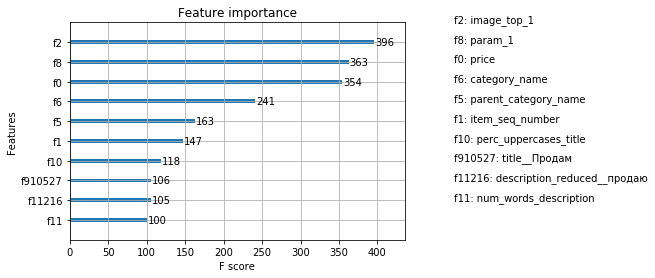

In [25]:
def show_features_importance(xgb):
    '''Essa função complicada é necessária pois ao salvar o modelo do XGBoost
    em disco ele não retem os dados dos nomes das features.
    Assim é necessario realizar um mapeamento dos nomes automaticos gerados pelo 
    modelo para os nomes das features originais.
      
    '''
    final_features_list = features + tfidf_features_name
    feature_map = {'f{}'.format(i): fname for i,fname in zip(range(len(final_features_list)), final_features_list)}
    feature_map_values = {'f{}'.format(i): value for i,value in zip(range(len(final_features_list)), xgb.feature_importances_)}
    sorted_feature_map_values = sorted(feature_map_values.items(), key=operator.itemgetter(1), reverse=True)
    top_10_features_codes = [x[0] for x in sorted_feature_map_values[:10]]
    
    top_10_features_legend = ['{}: {}'.format(fcode, feature_map[fcode]) for fcode in top_10_features_codes]
    
    importance_plt = plot_importance(xgb, max_num_features=10)
    for i, legend in enumerate(top_10_features_legend):
        plt.text(500, 10-i, legend)
    plt.show()

show_features_importance(xgb_reg_best)

### Comparativo final dos scores

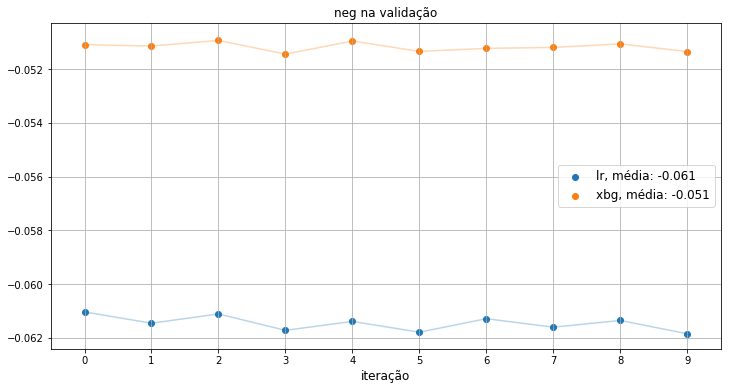

In [0]:
plot_metric(scores, ['test_neg_mean_squared_error'])

Como podemos ver o XGBRegressor teve um resultado muito melhor que o LinearRegressor em todos os folds da cross validation.

### Visualizando os resultados do predict na validação

Vamos gerar um dataset utilizando os dados previstos para o dataset de validação do treino e vamos comparar a distribuição dos resultados em relação ao resultado esperado. 

Devemos também limitar os resultados previstos entre 0 e 1. 

Assim qualquer valor negativo vira 0, e qualquer valor acima de 1 é transformado em 1.

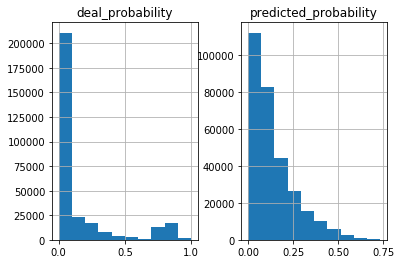

In [28]:
def limit_value(value):
    """Limita um valor entre 0 e 1.
    caso seja maior que 1, transforma em 1, e caso seja menor que 0
    transforma em 0
    """
    if value > 1:
        value = 1
    elif value < 0:
        value = 0
    return value

  
y_test_predict = xgb_reg_best.predict(X_test)
y_test_predict_treated = np.array(list(map(limit_value, y_test_predict)))

prediction_test_df = pd.DataFrame(
    {'predicted_probability': y_test_predict_treated, 'deal_probability': y_test}, 
)
prediction_test_df[['predicted_probability', 'deal_probability']].hist()
plt.show()

E vemos mais detalhes utilizando o describe.

In [29]:
prediction_test_df.describe()

,predicted_probability,deal_probability
count,300685.000000,300685.000000
mean,0.141679,0.139493
std,0.116530,0.260449
min,0.000000,0.000000
25%,0.053452,0.000000
50%,0.101444,0.000000
75%,0.193051,0.151780
max,0.733150,1.000000


## Submissão
Por fim iremos rodar o modelo escolhido no dataset que será utilizado para a submissão ao kaggle.

Neste ponto as features de entrada já estão prontas para serem utilizadas.

Novamente restringimos os valores do resultado para ficarem entre 0 e 1.

In [30]:
y_submission_predict = xgb_reg_best.predict(submission_X)
y_submission_predict_treated = np.array(list(map(limit_value, y_submission_predict)))

Podemos olhar como ficou a aparencia dos resultados previstos, e comparar com outros histogramas realizados em experimentos anteriores.

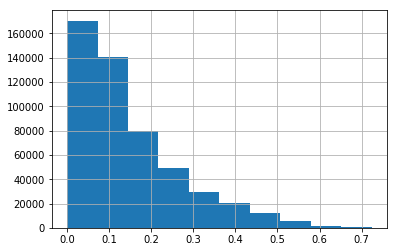

In [31]:
submission_prediction_df = pd.DataFrame(
    {'deal_probability': y_submission_predict_treated}, 
    index=submission_df.index)
submission_prediction_df['deal_probability'].hist()
plt.show()

Analisamos também mais detalhes do resultado, inclusive para conferir se de fato nenhum valor fora do intervalo esperado foi gerado.

In [32]:
submission_prediction_df['deal_probability'].describe()

count    508438.000000
mean          0.150341
std           0.119854
min           0.000000
25%           0.057571
50%           0.110739
75%           0.206599
max           0.723558
Name: deal_probability, dtype: float64

Novamente por segurança confirmamos que nenhum resultado está maior que 1 ou menor q zero, e que o tamanho da saida é exatamente do tamanho esperado

In [33]:
assert submission_prediction_df['deal_probability'].min() >= 0
assert submission_prediction_df['deal_probability'].max() <= 1
assert submission_prediction_df['deal_probability'].shape[0] == 508438

Geramos o CSV da submissão e então enviamos para o kaggle para uma avalialçao final.

In [0]:
submission_prediction_df.to_csv(
    'submission_xgb.csv'
)

Onde obtivemos como score 0.2316 e a colocação 1182 (Ver imagem abaixo)

![alt text][logo]

[logo]: https://raw.githubusercontent.com/arruda/avito_challenge/master/score.png "Logo Title Text 2"
